In [ ]:
#default_exp audio.core
#default_cls_lvl 3

In [ ]:
%matplotlib inline

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc
import torchaudio
import torchaudio.transforms as torchaud_tfm
import warnings

from IPython.display import display, Audio
from dataclasses import dataclass, asdict, is_dataclass, make_dataclass
from torchaudio.transforms import Spectrogram, AmplitudeToDB, MFCC
from librosa.display import specshow, waveplot

In [ ]:
torchaudio.__version__

'0.3.0+faed00e'

In [ ]:
#TensorBase??

In [ ]:
#export
_all_ = ['AudioGetter', 'get_audio_files', 'AudioItem', 'OpenAudio', 'AudioSpectrogram', 'AudioToSpec',
        'SpectrogramConfig', 'AudioConfig', 'audio_extensions']

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#export
audio_extensions = tuple(str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): 
        return get_audio_files(o/suf, recurse, folders)
    return _inner

In [ ]:
p = Path("/home/jupyter/.fastai/data/speakers")
URLs.SPEAKERS = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
untar_data(URLs.SPEAKERS, dest=p)

PosixPath('/home/jupyter/.fastai/data/speakers/ST-AEDS-20180100_1-OS')

In [ ]:
URLs.SPEAKERS = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
source = untar_data(URLs.SPEAKERS)

In [ ]:
source

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')

In [ ]:
p

PosixPath('/home/jupyter/.fastai/data/speakers')

In [ ]:
p.ls()

(#3843) [/home/jupyter/.fastai/data/speakers/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/speakers/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/speakers/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/speakers/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/speakers/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/speakers/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/speakers/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/speakers/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/speakers/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/speakers/m0003_us_m0003_00180.wav...]

In [ ]:
audio_get_func = AudioGetter("", recurse=True, folders=None)

In [ ]:
audio_get_func

<function __main__.AudioGetter.<locals>._inner(o, recurse=True, folders=None)>

In [ ]:
files = audio_get_func(p)

In [ ]:
files[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')


<div class='alert alert-block alert-warning'><strong>Notes:</strong><br> 
    <br>
    1. Return to lazy loading? (no longer needed as spectros and signals aren't grouped together 
    2. Should path really be part of tuple? Leave it for now
</div>


<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br> 
    1. Plotting doesnt currently work for multichannel display <br>
    2. Plotting multiple items in a row results in them displayed on one plot <br>
</div>

In [ ]:
#export
class AudioItem(tuple):
    def show(self, ctx=None, **kwargs): 
        print(f"File: {self.path}")
        display(Audio(self.sig, rate=self.sr))
        #won't work for multichannel display
        display(waveplot(self.sig.squeeze(0).numpy(), self.sr, ax=ctx, **kwargs))
    
    @classmethod
    def create(cls, fn, **kwargs):
        sig, sr = torchaudio.load(fn)
        return cls((sig, sr, fn))
    
    sig, sr, path = add_props(lambda i, self: self[i], n=3)
    nchannels, nsamples = add_props(lambda i, self: self.sig.shape[i])
    @property
    def duration(self): return self.nsamples/float(self.sr)

In [ ]:
type(AudioItem((None, None, files[0])))

__main__.AudioItem

In [ ]:
test_item = AudioItem.create(files[0]); test_item

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
          -6.1035e-05, -1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'))

In [ ]:
test_item[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
         -6.1035e-05, -1.8311e-04]])

In [ ]:
test_item.sr, test_item.duration, test_item.nchannels, test_item.nsamples

(16000, 3.28, 1, 52480)

In [ ]:
test_item.show()

AttributeError: 'AudioItem' object has no attribute 'show'

In [ ]:
#export
class OpenAudio(Transform):
    def __init__(self, items):
        self.items = items

    def encodes(self, i):
        o = self.items[i]
        return AudioItem.create(o)
    
    def decodes(self, i)->Path: 
        return self.items[i]

repr of Transform is:  
classname: self.use_as_item {self.encodes} {self.decodes}  
encodes and decodes are TypeDispatches whose reprs are str of dict where k/v pair is typename and function that handles that type

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True {'object': 'encodes'} {'object': 'decodes'}

In [ ]:
type(oa)

__main__.OpenAudio

In [ ]:
#??Transform
#??TypeDispatch

In [ ]:
oa.encodes(1)

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.0518e-05,
          -1.2207e-04,  1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav'))

In [ ]:
oa.decodes(1)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav')

In [ ]:
oa.items[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

## Create functions to wrap TorchAudio 

In [ ]:
#export
_GenSpec    = torchaudio.transforms.Spectrogram
_GenMelSpec = torchaudio.transforms.MelSpectrogram
_GenMFCC    = torchaudio.transforms.MFCC
_ToDB       = torchaudio.transforms.AmplitudeToDB

In [ ]:
omit = ["data"]
{k:v for k,v in inspect.signature(specshow).parameters.items() if k not in omit}

{'x_coords': <Parameter "x_coords=None">,
 'y_coords': <Parameter "y_coords=None">,
 'x_axis': <Parameter "x_axis=None">,
 'y_axis': <Parameter "y_axis=None">,
 'sr': <Parameter "sr=22050">,
 'hop_length': <Parameter "hop_length=512">,
 'fmin': <Parameter "fmin=None">,
 'fmax': <Parameter "fmax=None">,
 'bins_per_octave': <Parameter "bins_per_octave=12">,
 'ax': <Parameter "ax=None">,
 'kwargs': <Parameter "**kwargs">}

<div class='alert alert-block alert-warning'><strong></strong> If a function (e.g. specshow) accepts kwargs, this wont pass extra arguments because specshow doesnt accept all kwargs, and will break if you pass in unexpected ones, but we have no way of knowing what functions they delegate to and pulling out the relevant kwargs, so if there is something we know it accepts as a kwarg like "cmap" we need to pass it in manually</div

In [ ]:
#export
def get_usable_kwargs(func, args, exclude):
    exclude = ifnone(exclude, [])
    defaults = {k:v.default for k, v in inspect.signature(func).parameters.items() if k not in exclude and v.default is not None}
    usable = {k:v for k,v in args.items() if k in defaults}
    return {**defaults, **usable}

def add_func(func, kwargs):
    func_args = get_usable_kwargs(func, kwargs, [])
    return func(**func_args)

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br> 
    In spectrogram when we pad with mean value we mess up normalization by altering std dev, how can we use fill values that dont mess things up<br>
</div>

## Audio Spectrogram

In [ ]:
# TensorImageBase??
# TensorImage??
# TensorBase??
# Tensor??
# BypassNewMeta??

In [ ]:
#??TensorImageBase

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br>
    1. Add proper axis labels based on settings, get colorbar working <br>
    2. Clean up/Refactor <br>
    3. Add testing for plotting various channels/deltas<br>
</div><br>

<div class='alert alert-block alert-warning'><strong></strong> Duration isnt working, fix it</div

In [ ]:
#export
class AudioSpectrogram(TensorImageBase):
    @classmethod
    def create(cls, sg, settings=None):
        x = cls(sg)
        x.settings = settings
        return x
    
    @property
    def duration(self): return (self.hop*self.shape[-1])/self.sr
    
    def __getattr__(self, name):
        if name == "settings": return None
        if self.settings is not None and name in self.settings: return self.settings[name]
        
        raise AttributeError(f"{self.__class__.__name__} object has no attribute {name}")
        
#     def show(self, figsize=None, ax=None, ctx=None, **kwargs):
#         ax = ifnone(ax,ctx)
#         nchannels = self.nchannels
#         r, c = nchannels, self.data.shape[0]//nchannels
#         proper_kwargs = get_usable_kwargs(specshow, self.settings, omit=["kwargs", "data",])
#         if (r == 1 and c == 1):
#             _ = specshow(self.data.squeeze(0).numpy(), **self._show_args, **proper_kwargs)
            
#         else:
#             if figsize is None: figsize = (4*c, 3*r)
#             if ax is None: _,ax = plt.subplots(r, c, figsize=figsize)
#             for i, channel in enumerate(self.data):
#                 cur_ax = ax[i//c,i%c] if r > 1 else ax[i%c]
#                 cur_ax.set_title(f"Channel {i//c} Image {i%c}")
#                 _ = specshow(channel.numpy(), ax=cur_ax, **self._show_args, **proper_kwargs)
    
    

<div class='alert alert-block alert-info'><strong>Idea:</strong> Since we are grouping 3 functions signatures together here and it can get a bit confusing, we could add a check_kwargs in the init that warns if unused kwargs are being passed in. For instance if you pass in n_mels but mel=False, or top_db when to_db = False</div

In [ ]:
import inspect

<div class='alert alert-block alert-info'><strong>Note:</strong> Would it be better to use Pipeline here instead of nn.sequential?</div

<div class='alert alert-block alert-info'><strong>Note:</strong> _validate and _warn_kwargs should probably be abstracted up a level, they dont belong to AudioToSpec class and would be useful to check args in general.</div

In [ ]:
#export
@delegates(_GenSpec.__init__)
@delegates(_GenMelSpec.__init__, keep=True)
@delegates(_ToDB.__init__, keep=True)
class AudioToSpec(Transform):
    def __init__(self, mel=True, to_db=True, **kwargs):
        self._validate_kwargs(mel, to_db, kwargs)
        transforms = L()
        if mel:   transforms += add_func(_GenMelSpec, kwargs)
        else:     transforms += add_func(_GenSpec, kwargs)
        if to_db: transforms += add_func(_ToDB, kwargs)
        
        self.transformer = nn.Sequential(*transforms)
        store_attr(self, 'to_db,mel')
        self.__dict__.update(kwargs)
        
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else audio_cfg
        return cls(**cfg)
    
    def encodes(self, x:AudioItem):
        settings = dict(self.__dict__)
        settings.update({'sr':x.sr, 'nchannels':x.nchannels, 'path':x.path})
        return AudioSpectrogram.create(self.transformer(x.sig).flip(1).detach(), settings=settings)
    
    @staticmethod
    def _validate_kwargs(mel, to_db, kwargs):
        funcs = [_GenMelSpec, _GenSpec, _ToDB]
        all_args = set().union(*map(lambda x: set(inspect.signature(x).parameters.keys()), funcs))
        for k, v in kwargs.items():
            if k not in all_args:
                warnings.warn(f"{k} is not a valid arg name, usable kwargs are {all_args}")
        if mel:       AudioToSpec._warn_kwargs(_GenMelSpec, _GenSpec, kwargs)  
        else  :       AudioToSpec._warn_kwargs(_GenSpec, _GenMelSpec, kwargs)
        if not to_db: AudioToSpec._warn_kwargs(noop, _ToDB, kwargs)
    
    @staticmethod
    def _warn_kwargs(used, unused, kwargs):
        def get_bad_args(f1, f2):
            a1, a2 = map(lambda x: set(inspect.signature(x).parameters.keys()), (f1, f2))
            return a2 - a1
        bad_args = get_bad_args(used, unused)
        for k, v in kwargs.items():
            if(k in bad_args):
                warnings.warn(f"{k} passed in but unused, your settings use {used} not {unused}")

In [ ]:
#export
@delegates(_GenMFCC.__init__)
class AudioToMFCC(Transform):
    def __init__(self,**kwargs):
        self.transformer = add_func(_GenMFCC, kwargs)
        self.__dict__.update(kwargs)
        
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else audio_cfg
        return cls(**cfg)
    
    def encodes(self, x:AudioItem):
        self.sr, self.nchannels = x.sr, x.nchannels
        return AudioSpectrogram.create(self.transformer(x.sig).flip(1).detach(), settings=self.__dict__)

In [ ]:
_GenSpec.__name__

'Spectrogram'

In [ ]:
a2s = AudioToSpec()

In [ ]:
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256, 'power':2}
AudioToSpec(**voice_mel_cfg)


/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: power passed in but unused, your settings use <class 'torchaudio.transforms.MelSpectrogram'> not <class 'torchaudio.transforms.Spectrogram'>


AudioToSpec: True {'AudioItem': 'encodes'} {}

In [ ]:
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256, 'power':2}
AudioToSpec(mel = False, **voice_mel_cfg)

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: f_max passed in but unused, your settings use <class 'torchaudio.transforms.Spectrogram'> not <class 'torchaudio.transforms.MelSpectrogram'>
/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: n_mels passed in but unused, your settings use <class 'torchaudio.transforms.Spectrogram'> not <class 'torchaudio.transforms.MelSpectrogram'>


AudioToSpec: True {'AudioItem': 'encodes'} {}

In [ ]:
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256, 'top_db':20}
AudioToSpec(to_db=False, **voice_mel_cfg)

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: top_db passed in but unused, your settings use <function noop at 0x7fea8fd38dd0> not <class 'torchaudio.transforms.AmplitudeToDB'>


AudioToSpec: True {'AudioItem': 'encodes'} {}

In [ ]:
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256, 'doesntexist':True}
AudioToSpec(to_db=False, **voice_mel_cfg)

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: doesntexist is not a valid arg name, usable kwargs are {'hop_length', 'pad', 'window_fn', 'normalized', 'f_max', 'stype', 'f_min', 'top_db', 'power', 'sample_rate', 'n_mels', 'win_length', 'n_fft', 'wkwargs'}


AudioToSpec: True {'AudioItem': 'encodes'} {}

In [ ]:
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()
a2s = AudioToSpec(**voice_mel_cfg)
sg = a2s(item100)

AttributeError: 'AudioItem' object has no attribute 'show'

In [ ]:
sg.__dict__

{'settings': {'transformer': Sequential(
    (0): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
    (1): AmplitudeToDB()
  ),
  'to_db': True,
  'mel': True,
  'n_fft': 2560,
  'f_max': 22050.0,
  'n_mels': 128,
  'hop_length': 256,
  'doesntexist': True,
  'sr': 16000,
  'nchannels': 1,
  'path': PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav')}}

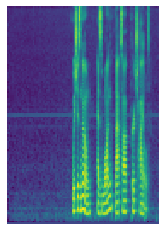

In [ ]:
sg.show()

In [ ]:
item100.duration

7.08

In [ ]:
sg.shape

torch.Size([1, 128, 89])

In [ ]:
sg.sr

16000

In [ ]:
sg.hop_length

256

In [ ]:
(sg.hop_length*sg.shape[-1])/sg.sr

1.424

In [ ]:
AudioToMFCC()

AudioToMFCC: True {'AudioItem': 'encodes'} {}

<div class='alert alert-block alert-warning'><strong>Issue:</strong><br>
    Pipe is only displaying one thing instead of multiple, this is because I am not strong with matplotlib and the plot is being overwritten each time show is called, get someone who knows this and how it fits into fastai to fix</div><br>

### MelSpecPipe

In [ ]:
mel_cfg = {'n_fft':2560,'hop_length':64}
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()
a2s = AudioToSpec(**mel_cfg)
sg100 = a2s(item100)
sg100.show()
print("hop:", sg100.hop_length)
db_mel_pipe = Pipeline([oa,a2s], as_item=True)
for i in range(5): 
    db_mel_pipe.show(db_mel_pipe(i))

AttributeError: 'AudioItem' object has no attribute 'show'

### Raw Spec Pipe

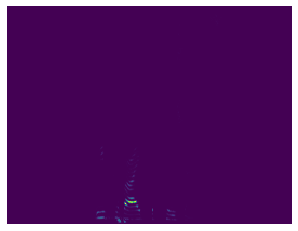

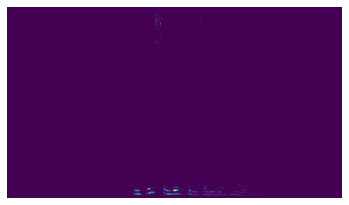

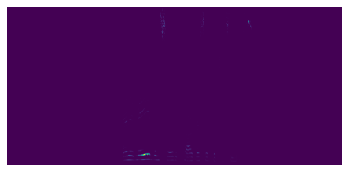

In [ ]:
cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec(mel=False, to_db=False,)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### DBScale non-mel Pipe

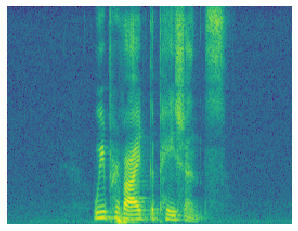

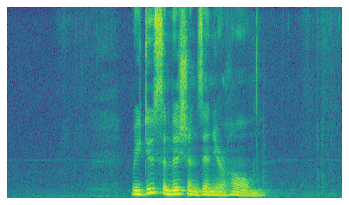

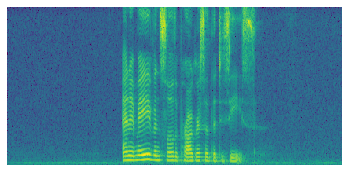

In [ ]:
cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec(mel=False)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### from config pipe 

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: f_max passed in but unused, your settings use <class 'torchaudio.transforms.Spectrogram'> not <class 'torchaudio.transforms.MelSpectrogram'>


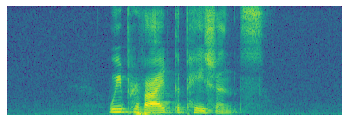

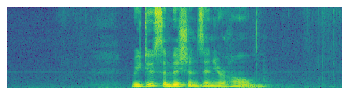

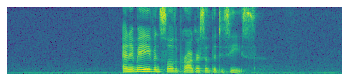

In [ ]:
cfg = {'mel':False, 'n_fft':260, 'f_max':22050., 'hop_length':128}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### MFCC Pipe

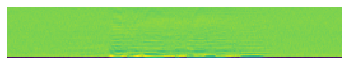

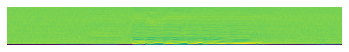

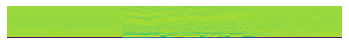

In [ ]:
db_mfcc_pipe = Pipeline([oa, AudioToMFCC(n_mfcc=40),], as_item=True)
for i in range(3): 
    db_mfcc_pipe.show(db_mfcc_pipe(i))

## Configs

<div class='alert alert-block alert-warning'><strong>Issue:</strong><br>
    Create a config class so we can have tab completion for the options
</div><br>

In [ ]:
#export
def config_from_func(func, name, **kwargs):
    args = inspect.signature(func).parameters
    namespace = {k:v.default for k, v in args.items()}
    namespace.update(**kwargs)
    return make_dataclass(name, args, namespace=namespace)

#default configurations from the wrapped function
SpectrogramConfig    = config_from_func(_GenSpec, "SpectrogramConfig")
MelSpectrogramConfig = config_from_func(_GenMelSpec, "MelSpectrogramConfig")
MFCCConfig           = config_from_func(_GenMFCC, "MFCCConfig")
#special configs with domain-specific defaults
VoiceMelConfig = config_from_func(_GenMelSpec, "VoiceMelConfig", f_min=50., f_max=8000., n_mels=64)

In [ ]:
MelSpectrogramConfig()

MelSpectrogramConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=None, f_min=0.0, f_max=None, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7fea8f7fe0a0>, wkwargs=None)

In [ ]:
sg_cfg = SpectrogramConfig(n_fft=2000); sg_cfg

SpectrogramConfig(n_fft=2000, win_length=None, hop_length=None, pad=0, window_fn=<built-in method hann_window of type object at 0x7fea8f7fe0a0>, power=2, normalized=False, wkwargs=None)

In [ ]:
MelSpectrogramConfig(hop_length=128)

MelSpectrogramConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=128, f_min=0.0, f_max=None, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7fea8f7fe0a0>, wkwargs=None)

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: power passed in but unused, your settings use <class 'torchaudio.transforms.MelSpectrogram'> not <class 'torchaudio.transforms.Spectrogram'>
/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: normalized passed in but unused, your settings use <class 'torchaudio.transforms.MelSpectrogram'> not <class 'torchaudio.transforms.Spectrogram'>


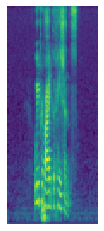

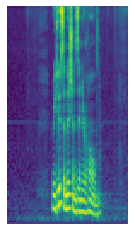

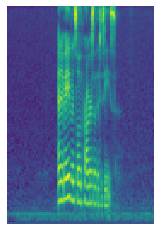

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
vm = VoiceMelConfig(); vm

VoiceMelConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=None, f_min=50.0, f_max=8000.0, pad=0, n_mels=64, window_fn=<built-in method hann_window of type object at 0x7fea8f7fe0a0>, wkwargs=None)

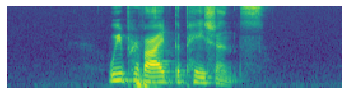

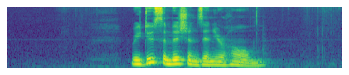

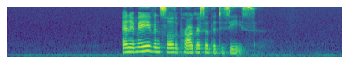

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(vm)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
MFCCConfig()

MFCCConfig(sample_rate=16000, n_mfcc=40, dct_type=2, norm='ortho', log_mels=False, melkwargs=None)

In [ ]:
VoiceMelConfig()

VoiceMelConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=None, f_min=50.0, f_max=8000.0, pad=0, n_mels=64, window_fn=<built-in method hann_window of type object at 0x7fea8f7fe0a0>, wkwargs=None)

## Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01b_script.ipynb.
Converted 01c_dataloader.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Conve